In [3]:
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt

keras.__version__

'2.2.5'

In [ ]:
## [deskew]
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]

def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

# A first look at a neural network

We will now take a look at a first concrete example of a neural network, which makes use of the Python library Keras to learn to classify 
hand-written digits. Unless you already have experience with Keras or similar libraries, you will not understand everything about this 
first example right away. You probably haven't even installed Keras yet. Don't worry, that is perfectly fine. In the next chapter, we will 
review each element in our example and explain them in detail. So don't worry if some steps seem arbitrary or look like magic to you! 
We've got to start somewhere.


(60000, 28, 28)
255
0


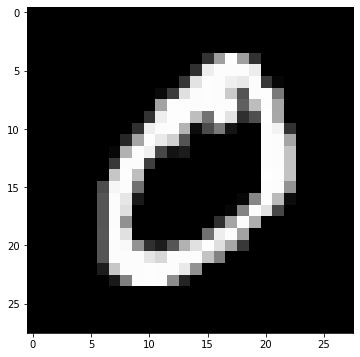

60000
[5 0 4 ... 5 6 8]
(10000, 28, 28)
[7 2 1 ... 4 5 6]


In [7]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)

print(np.max(train_images[1]))
print(np.min(train_images[1]))

showOpencvImage(train_images[1])

print(len(train_labels))

print(train_labels)

print(test_images.shape)

print(test_labels)

70000


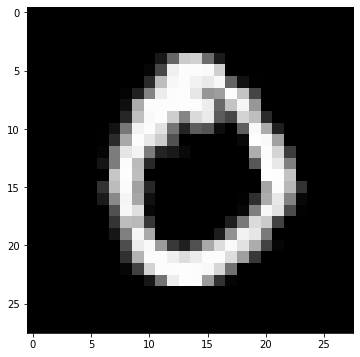

In [8]:

im_list = [train_images[i] for i in range(0,train_images.shape[0])] + [test_images[i] for i in range(0,test_images.shape[0])]
print(len(im_list))
train_deskewed = [deskew(im) for im in im_list[0:train_images.shape[0]]]
test_deskewed = [deskew(im) for im in im_list[train_images.shape[0]:]]

showOpencvImage(train_deskewed[1])

Our workflow will be as follow: first we will present our neural network with the training data, `train_images` and `train_labels`. The 
network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we 
will verify if these predictions match the labels from `test_labels`.

Let's build our network -- again, remember that you aren't supposed to understand everything about this example just yet.

In [9]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))


The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some 
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully 
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers 
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 
The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each 
score will be the probability that the current digit image belongs to one of our 10 digit classes.

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).

In [10]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

**We also need to categorically encode the labels**

In [12]:
from keras.utils import to_categorical

encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

encoded_test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data.

In [14]:
network.fit(train_images, encoded_train_labels, epochs=5, batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





60000/60000 [==============================] - 6s 94us/step - loss: 0.2609 - acc: 0.9243
Epoch 2/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.1083 - acc: 0.9682
Epoch 3/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0719 - acc: 0.9783
Epoch 4/5
60000/60000 [==============================] - 5s 83us/step - loss: 0.0538 - acc: 0.9840
Epoch 5/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.0409 - acc: 0.9880


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over 
the training data.

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. Now let's check that our model performs well on the test set too:

In [16]:
test_loss, test_acc = network.evaluate(test_images, encoded_test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 1s 53us/step
test_acc: 0.9779


Our test set accuracy turns out to be 97.8% -- that's quite a bit lower than the training set accuracy. 
This gap between training accuracy and test accuracy is an example of "overfitting", 
the fact that machine learning models tend to perform worse on new data than on their training data. 
Overfitting will be a central topic in chapter 3.

This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in 
less than 20 lines of Python code.

Finally let us look at what the network outputs

In [17]:
pred_probabilities = network.predict(test_images)
print(pred_probabilities[0:1])

[[4.1675505e-10 4.1147680e-12 2.4557676e-07 3.9618626e-06 6.1026298e-14
  1.0904273e-09 1.0335507e-16 9.9999583e-01 2.1403472e-09 4.4509086e-08]]


7


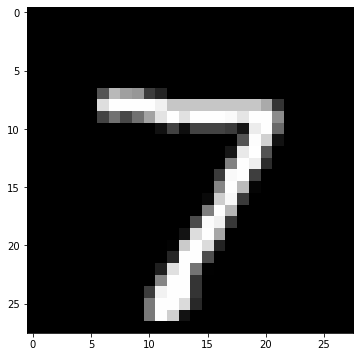

In [21]:
pred_labels = np.argmax(pred_probabilities,-1)
print(pred_labels[0])
showOpencvImage(test_images[0].reshape(28,-1))

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(classification_report(test_labels, pred_labels))


[[ 971    0    1    0    1    0    2    1    3    1]
 [   0 1123    4    1    0    1    2    2    2    0]
 [   3    2 1010    0    2    0    1    6    7    1]
 [   0    0    3  989    0    2    0    7    3    6]
 [   1    0    3    0  965    0    2    1    1    9]
 [   2    0    0    7    2  879    1    0    0    1]
 [   5    3    3    1    9   19  915    0    3    0]
 [   1    3    9    3    1    0    0 1005    2    4]
 [   2    0    5    5    5    8    0    6  936    7]
 [   3    2    0    3    7    1    0    6    1  986]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.96      0.97       958
           7       0.97      0.98   